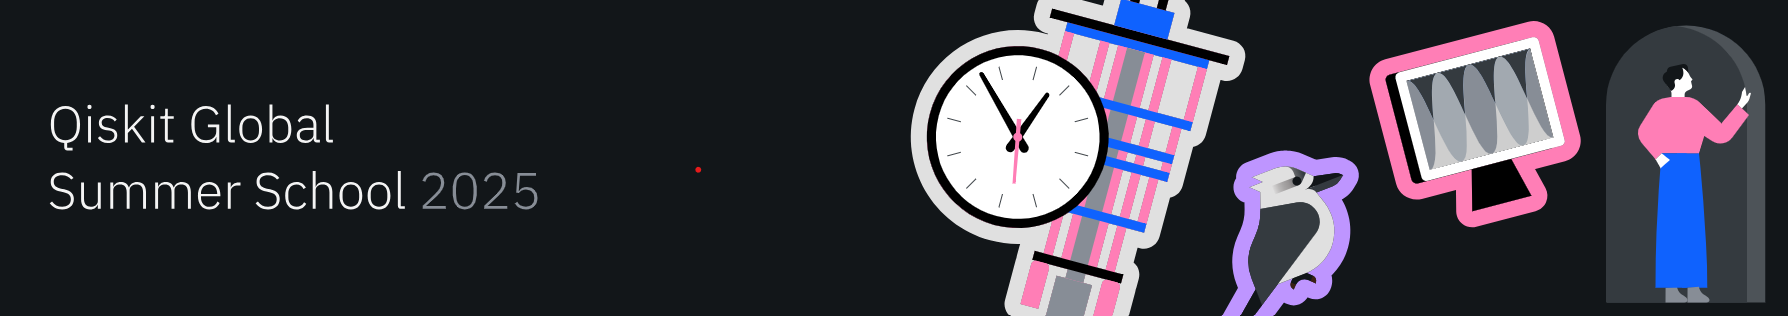

# Lab 2: Cutting through the noise

In this lab we dive into the world of quantum noise, and explore the different techniques for navigating the challenges of noise in order to obtain good results with current quantum computers. In the context of a small-size Max-cut problem, we provide a step-by-step guide to reduce noise in order to execute a quantum algorithm on a quantum computer. We present different transpilation and error mitigation techniques to minimize the error and ensure that the results remain correct despite the noise. Finally, the lab concludes with a bonus exercise where all the discussed techniques are implemented on real quantum hardware.

# Table of contents

0. [Requirements](#requirements)
1. [Introduction](#intro)  
    - [Spirit of the Lab](#spirit)
    - [What is quantum noise?](#quantum-noise)  
    - [Sources of noise](#sources)
        * [Exercise 1: Find the qubits with longer T1, T2, higher gate fidelities, and smaller readout errors](#exercise_1)
2. [Max-cut problem](#max-cut)
    - [The problem: Define the graph](#the-graph)
    - [The mapping: a graph into a quantum computer](#the-mapping)
        * [Exercise 2: Find the Ising Hamiltonian of the Max-cut problem](#exercise_2)
    - [QAOA solution](#qaoa-solution)
    - [Checking our solution](#checking)
3. [Noisy quantum simulator](#noisy-simulator)
    - [Choosing backend](#choosing-backend)
        * [Exercise 3: Counting errors](#exercise_3)
    - [Estimating errors using NEAT](#neat)
4. [Transpiler](#transpiler)
    - [Minimizing two-qubit gates](#min-two-qubit)
    - [Find the optimal layout](#opt-layout)
        * [Exercise 4: Find all the good mappings](#exercise_4)
        * [Exercise 5: Use the transpiler to find the optimal layout](#exercise_5)
5. [Error mitigation](#em)
    - [Zero Noise Extrapolation (ZNE)](#zne)
        * [Exercise 6a: Implement global folding on quantum circuits](#exercise_6a)
        * [Exercise 6b: Implement local  folding on quantum circuits](#exercise_6b)
        * [Exercise 7: Implement Local Zero Noise Extrapolation (ZNE)](#exercise_7)
6. [Conclusions](#conclusions)
7. [Bonus challenge: Scale it up!](#bonus)

<a id="requirements"></a>

## 0. Requirements 

Before starting this tutorial, please make sure that you have the following libraries installed:

* Qiskit SDK v2.0 with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime v0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx (`pip install rustworkx`)
* Qiskit Aer v0.17
* Pylatexenc


In [1]:
%pip install -U qiskit "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /private/var/folders/50/bmygb_vs4w7dcx715g_jnpq40000gn/T/pip-install-kefyv9bg/qc-grader_1bdd82c01b924cc8bf5fa570589c716d
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /private/var/folders/50/bmygb_vs4w7dcx715g_jnpq40000gn/T/pip-install-kefyv9bg/qc-grader_1bdd82c01b924cc8bf5fa570589c716d
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 897f4448b14d18b4d0a430f57f11c2dcb6200c20
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import qiskit
import qc_grader

print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.9


You should have Qiskit version `>=2.0.0` and Grader `>=0.22.9`. If you see a lower version, restart your kernel and reinstall the grader.
Also make sure you have set up everything according to lab 0 and test it with the cell below.

In [3]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(name="qgss-2025")

# Imports

In [4]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

## 1. Introduction <a id="intro"></a>

### 1.1 Spirit of the lab <a id="spirit"></a>


*Here we walk you through the process of tackling real-world problems by using the right transpilation and error mitigation techniques to maximize performance on IBM quantum hardware*

### 1.2 What is quantum noise? <a id="quantum-noise"></a>

Noise is a central topic in designing and using quantum computers, and it is one of the main characteristics of current devices. But what exactly does noise mean in quantum information? We usually refer to the term noise as any undesired transformation that disturbs the expected outcome of the measurement of a quantum state. We categorize errors in two groups:

- Coherent errors: These errors are caused by small, consistent mistakes in how quantum operations (gates) are applied. These errors are unitary, meaning they don't destroy information and can, in theory, be reversed. A typical example is a gate that's supposed to rotate a qubit by an angle $\theta$, but instead rotates it by $\theta+\varepsilon$ due to imperfect calibration. For instance, if a Hadamard gate is slightly miscalibrated, it might not create a perfect superposition, producing a biased measurement outcome.
- Incoherent errors: The origin of these errors is naturally quantum as it comes from the interaction of the quantum system with the environment. Incoherent errors are the reason why most of the current quantum computers need to be cooled down to a temperature of the order of mK, to reduce these unwanted interactions and preserve the system's coherence. These interactions create mixed states, which introduce randomness into the output and make these errors particularly problematic. A concrete example is $T_1$ relaxation time, which describes how a qubit in the excited state $|1\rangle$ spontaneously decays to the ground state $∣0\rangle$ over time. If a measurement is delayed, this decay can cause the qubit to flip states, leading to incorrect results.

### 1.3 Sources of noise <a id="sources"></a>

As mentioned above, some sources of noise come from different factors, including imperfect implementation of quantum gates as electromagnetic pulses, readout errors, decoherence of the quantum system, and so on.

Among the different metrics that can be used to evaluate how good or noise-resilient a quantum computer (or a qubit) is against sources of noise, we can distinguish a few:

* T1: relaxation time, is a decay constant that measures how quickly a qubit in state $|1\rangle$ decays into state $|0\rangle$.
* T2: dephasing time, is a decay constant that measures how quickly a qubit in state $|+\rangle$ becomes an indistinguishable mixture of $|+\rangle$ and $|-\rangle$ states.
* Single-qubit gate fidelity quantifies how closely the actual operation $\mathcal{E}$ performed by the hardware matches the ideal single-qubit unitary $U$. A fidelity of 1 means the gate behaves exactly as intended, with no deviation from the ideal case.
* Two-qubit gate fidelity quantifies how closely the actual operation $\mathcal{E}_2$ performed by the hardware matches the ideal single-qubit unitary $U_2$. Since these gates are more complex, they tend to have lower fidelities. As in the single-qubit case, a fidelity of 1 represents a perfect match.
* Readout assignment error: probability that a qubit is measured incorrectly, implying that the measured classical bit does not match the actual quantum state of the qubit just before measurement.

You can see information about specific IBM quantum devices on the [IBM Quantum Cloud Platform](https://quantum.cloud.ibm.com/computers). Click the device you want to analyze to see detailed characteristics of each qubit, along with a summary of the machine's overall properties. The image below shows an example of this summary for the device `ibm_brisbane`.

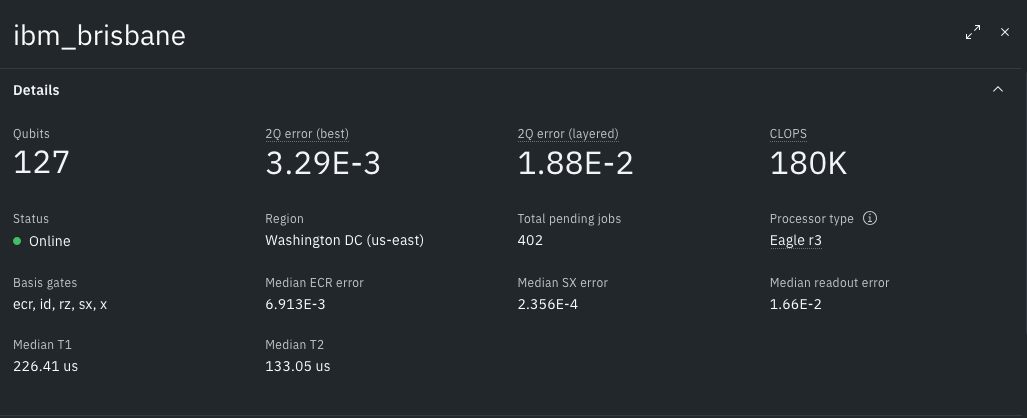

You can also access this information about the devices directly through code.

Let's see how it's done!

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 1: Find the best qubits </b> 

**Your Goal:** Find the qubits with longer T1, T2, higher gate fidelities, and smaller readout errors.

In this first exercise, you will provide the best value of each of the following metrics, as well as the qubit, or pair of qubits, that have this value:

- Relaxation time: T1
- Dephasing time: T2
- Readout error
- Single-qubit gate error: 'PauliX' error
- Two-qubits gate error: 'Ecr' error 

To make your solution robust, you should write a routine that works for any backend.

<i>Note 1: The ECR gate is the two-qubit gate specific to this backend and may differ on other quantum devices, which might have CZ or CNOT gates. You can check the basis gate of backend by using [backend.basis_gates](/docs/api/qiskit-ibm-runtime/ibm-backend).</i>

<I>Note 2: Since the best-performing qubits and their values can change over time, we recommend finding these values across all qubits directly using Python's `min()` and `max()` functions for each run.</i>


</div>

The code below demonstrates how to retrieve and store properties for all qubits from the `ibm_brisbane` backend into an array. Use this as a reference when implementing your function.

In [5]:
# Execute to make arrays of properties
service = QiskitRuntimeService(name="qgss-2025")
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))

In [ ]:
def find_best_metrics(backend: QiskitRuntimeService.backend) -> list[tuple[int or list, float]]:
    """Finds the best-performing qubits and qubit pair based on various hardware metrics."""
    # ---- TODO : Task 1 ---
    # Goal: Obtain the best value and the index or indices of the qubits of the following metrics:
    # We obtain the system properties, number of qubits and coupling map
    properties = backend.properties()
    num_qubits = backend.num_qubits
    coupling_map = backend.coupling_map

    # We define various lists of metrics for all the qubits of the backend
    t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
    for i in range(num_qubits):
        t1.append(properties.t1(i))
        t2.append(properties.t2(i))
        gate_error_x.append(properties.gate_error(gate="x", qubits=i))
        readout_error.append(properties.readout_error(i))
    for pair in coupling_map:
        gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))
    
    #find the best qubit (index_t1_max) with the longest T1 and its value (max_t1)
    index_t1_max = t1.index(max(t1))
    max_t1 = t1[index_t1_max]

    #find the best qubit (index_t2_max) with the longest T2 and its value (max_t2)
    index_t2_max = t2.index(max(t2))
    max_t2 = t2[index_t2_max]

    #find the best qubit (index_min_x_error) with the smallest x gate error and its value (min_x_error)
    index_min_x_error = gate_error_x.index(min(gate_error_x))
    min_x_error = gate_error_x[index_min_x_error]

    #find the best qubit (index_min_readout) with the smallest readout error and its value (min_readout)
    index_min_readout= readout_error.index(min(readout_error))
    min_readout = readout_error[index_min_readout]

    #find the best qubit pairs with minimum ecr error (min_ecr_pair) and its value (min_ecr_error)
    index_min_ecr_pair = gate_error_ecr.index(min(gate_error_ecr))
    min_ecr_pair = coupling_map.get_edges()[index_min_ecr_pair]
    min_ecr_error = gate_error_ecr[index_min_ecr_pair]
    
    # --- End of TODO ---

    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    return solutions

In [7]:
# Submit your answer using the following code
grade_lab2_ex1(find_best_metrics)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


Good job! You've learned how to access the device properties and search for specific characteristics among them. Perhaps at this point you might be wondering whether we cannot simply look for the qubits with the best metrics. Well, it is not that easy. 

If you print the indices of the qubits you've obtained, you can see that they aren't clustered in a specific region of the device. Instead, they're spread out across different areas. This highlights a key challenge: a qubit with long relaxation time might also have a large single-qubit gate error, or vice versa. These trade-offs mean that choosing qubits based only on one metric may not lead to optimal performance for certain quantum algorithms. Furthermore, you also need to take into account that not all the qubits are connected, as shown on the coupling map. These factors make the task of choosing the specific layout of qubits an intricate, but fascinating, challenge. Fortunately for us, in Qiskit there's a dedicated tool designed to handle this problem: **the transpiler**. 

We'll explore the transpiler in detail in a later section.

# 2. The problem: Max-cut <a id="max-cut"></a>

The maximum cut ([Max-cut](https://en.wikipedia.org/wiki/Maximum_cut)) problem is a graph problem that lies in the category of [NP-hard](https://en.wikipedia.org/wiki/NP-hardnes), which means no algorithm exists that can solve it in polynomial time. Max-cut is an optimization problem with a wide range of applications including clustering, network science, statistical physics, and machine learning. The goal of this problem is to divide the nodes of a graph into two sets using a single cut, in such a way that the number of edges traversed by this cut is maximized. 
Let's visualize it with one example. 

In the picture below you see the max-cut solution of a five-node problem that exemplifies how the graph is divided, maximizing the number of edges cut. Another way to view this problem is to consider that finding the maximum cut in a graph means identifying a way to divide the nodes into two groups such that the number of edges connecting nodes from different groups is as large as possible.

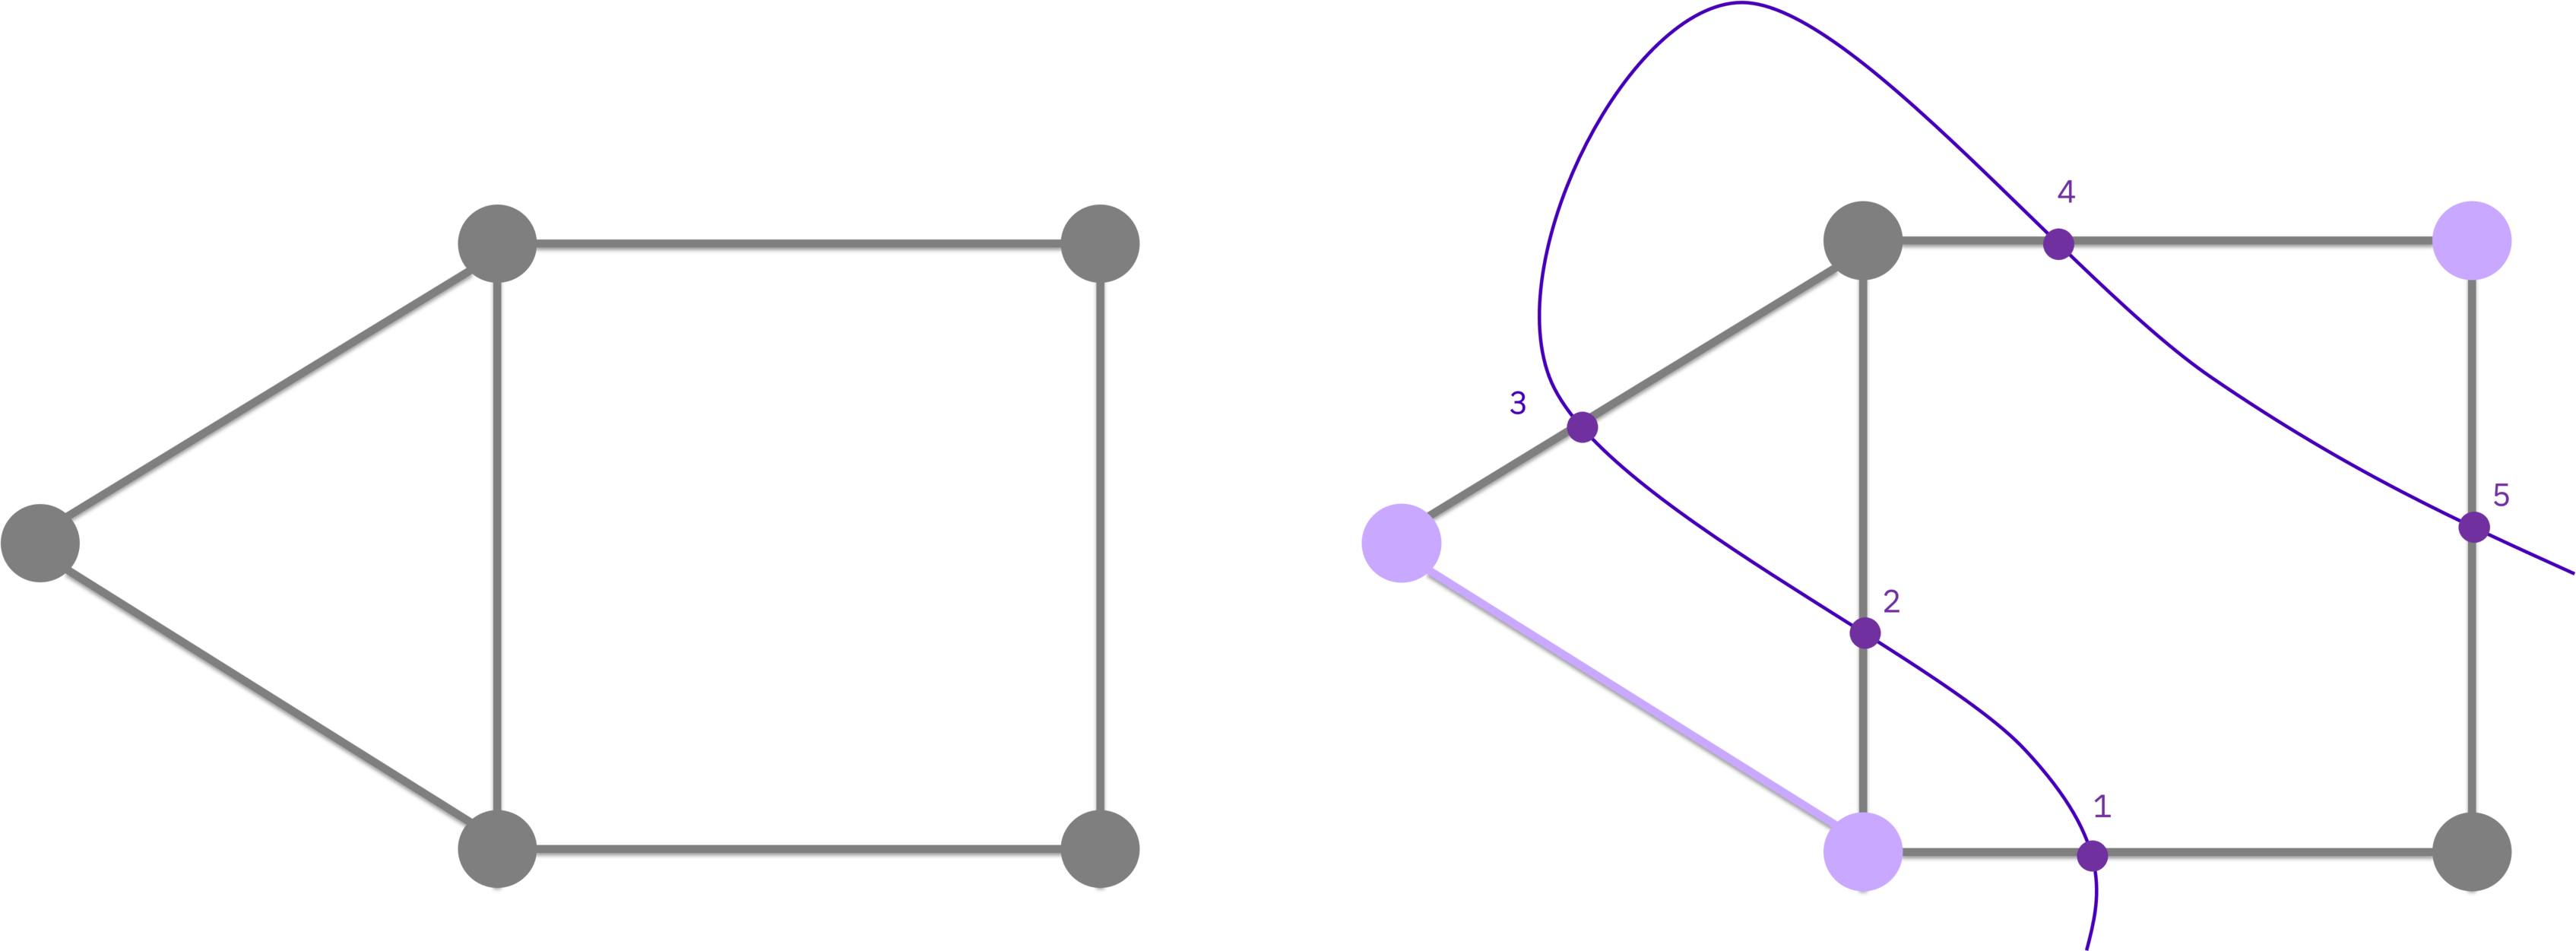

In this lab, we will solve a Max-cut problem using a quantum algorithm. We'll also study how quantum noise affects our solution and discuss strategies to reduce its impact, ensuring we can still obtain accurate results despite the noise.

## 2.1 The problem: Define the graph <a id="the-graph"></a>

Now that we have a little bit of context of the Max-cut problem, let's choose a specific graph for which we want to find the maximum cut. In particular, we will choose the graph of the coupling map of a hypothetical quantum computer with all-to-all connectivity $^*$.

$^*$ *Note that the last qubit is not actually connected to the first one, to explicitly break the symmetry of the problem and reduce the number of solutions.*

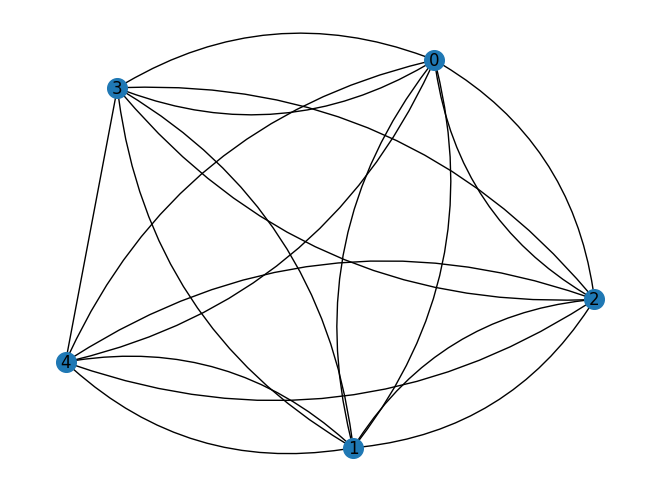

In [8]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

## 2.2 The mapping: a graph into a quantum computer <a id="the-mapping"></a>

To solve our graph problem with a quantum computer, we must first translate it into a language the computer understands. A common and powerful approach is to reframe the optimization problem in terms of a **Hamiltonian**, a mathematical object from quantum mechanics that describes the total energy of a system. The solution to our problem will then be encoded in the lowest energy state (the "ground state") of this Hamiltonian.

There are two closely related languages for formulating such problems:

1.  **QUBO (Quadratic Unconstrained Binary Optimization):** This is a language often used in computer science and classical optimization. It uses binary variables **x<sub>i</sub> ∈ {0, 1}** and seeks to minimize an objective function of the form:
    
    $$ \text{minimize} \sum_{i} Q_{ii}x_{i} + \sum_{i<j} Q_{ij}x_{i}x_{j} $$

2.  **Ising Model:** This language originates from statistical physics and is a natural fit for quantum systems. It uses spin variables **s<sub>i</sub> ∈ {+1, -1}** and seeks to minimize an energy Hamiltonian of the form:

    $$ H = -\sum_{i} h_{i}s_{i} - \sum_{i<j} J_{ij}s_{i}s_{j} $$

These two formalisms are equivalent and can be converted into one another using the simple linear transformation: **s<sub>i</sub> = 2x<sub>i</sub> - 1**.

For this lab, we will map our graph problem directly to an **Ising Hamiltonian**. This is the most direct path for a quantum computer because the eigenvalues of the Pauli Z operator are **+1** and **-1**, which perfectly correspond to the spin variables **s<sub>i</sub>** in the Ising model.

### From Max-cut to an Ising Hamiltonian

For the Max-cut problem on a graph $G = (V, E)$, we want to partition the vertices $V$ into two sets. The goal is to maximize the number of edges connecting vertices in different sets. We can express this objective using our spin variables **s<sub>i</sub>**. If two connected nodes `i` and `j` are in different partitions (s<sub>i</sub> ≠ s<sub>j</sub>), the term $s_i * s_j$ will be -1. If they are in the same partition (s<sub>i</sub> = s<sub>j</sub>), the term will be +1.

To *maximize* the cuts, we want to *minimize* the sum of $s_i * s_j$ over all connected edges. This gives us our cost Hamiltonian:

$$ H_{cost} = \sum_{(i,j) \in E} Z_i \otimes Z_j $$

Here we've replaced the classical spin variables `s_i` with their quantum counterparts, the Pauli **Z<sub>i</sub>** operators, which act on the `i`-th qubit. The ground state of this Hamiltonian is the specific arrangement of qubit states (`|0⟩` or `|1⟩`) that minimizes this energy, directly giving us the solution to the Max-cut problem.

Please refer this [tutorial](https://quantum.cloud.ibm.com/docs/tutorials/quantum-approximate-optimization-algorithm) for more details.

That's exactly what the next exercise is all about!

<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 2: From Graph to Hamiltonian </b> 

**Your Goal:** Convert the 'graph' object we just created into an Ising Hamiltonian, which is the cost function for our Max-cut problem.

In this second exercise you must find the way of mapping the graph problem you are given to a Hamiltonian using the identity and Pauli gates.




</div>

<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    The intuition of how to build this Hamiltonian consists of considering a Hilbert space of size n x n in which we add as many terms as edges in the graph, and in which the nodes connected by each edge are represented by Pauli-Z matrices, whereas the rest of the nodes are represented by the identity. <br> <br>
    You can find useful functions in the <a href=https://quantum.cloud.ibm.com/docs/tutorials/advanced-techniques-for-qaoa#graph--hamiltonian>Graph to Hamiltonian</a> section of the <a href="https://quantum.cloud.ibm.com/docs/tutorials/advanced-techniques-for-qaoa">Advanced techniques for QAOA </a>tutorial mentioned above.
    
</details>
</div>

In [9]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []

    # ---- TODO : Task 2 ---
    # Goal: Convert the graph into a list like: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]
    n = len(graph.node_indices())
    
    # Iterate through all edges in the graph
    for edge in graph.edge_list():
        i, j = edge[0], edge[1]
        
        # Create Pauli string with Z at positions i and j, I everywhere else
        pauli_str = ['I'] * n
        pauli_str[n-1-i] = 'Z'  # Reverse indexing for Qiskit convention (rightmost = qubit 0)
        pauli_str[n-1-j] = 'Z'
        
        # Convert list to string
        pauli_word = ''.join(pauli_str)
        
        # Weight is 1.0 for all edges (as defined in the original graph creation)
        weight = 1.0
        
        # Add to the Pauli list
        pauli_list.append((pauli_word, weight))
    # --- End of TODO ---

    return pauli_list


max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


In [10]:
# Submit your answer using the following code
grade_lab2_ex2(graph_to_Pauli)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# 2.3 QAOA solution <a id="qaoa-solution"></a>

Now that we have successfully mapped our Max-cut problem to an Ising Hamiltonian, we have translated a classical graph problem into a quantum ground state search problem. The solution to the original problem is encoded in the state with the lowest possible energy (the "ground state") of this Hamiltonian.

Several quantum algorithms can be employed to find this ground state. One of the most prominent is the Quantum Approximate Optimization Algorithm ([QAOA](https://en.wikipedia.org/wiki/Quantum_optimization_algorithms)). QAOA is known for its adaptability, relatively shallow circuit depth, and strong performance across a range of optimization tasks.


If you want a full description of QAOA, we recommend this [tutorial](https://quantum.cloud.ibm.com/docs/tutorials/quantum-approximate-optimization-algorithm) as well as the [Utility-scale QAOA](https://quantum.cloud.ibm.com/learning/courses/quantum-computing-in-practice/utility-scale-qaoa) lesson from the Quantum computing in practice course. Here, we will briefly comment on the main idea behind it. 

QAOA is a variational quantum algorithm inspired by the adiabatic theorem, which states that a quantum system remains in its ground state if it evolves slowly enough. QAOA mimics this by starting in the ground state of a known Hamiltonian (the mixer) and evolving toward the ground state of a Hamiltonian that encodes our problem (the cost). This is done through alternating layers of the two Hamiltonians, with each step controlled by tunable parameters that guide the system toward the optimal solution.

After this little explanation of the theory, let's get some hands-on practice using `QAOAAnsatz` from Qiskit to implement QAOA and solve our Max-cut problem.

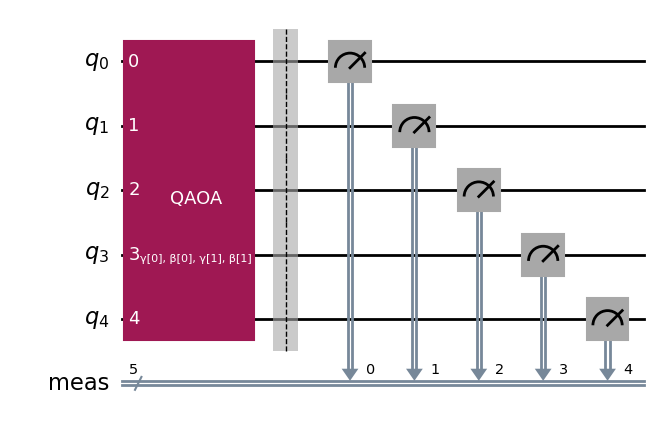

In [11]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

After we define the QAOA circuit, we must pass it to the pass manager to transpile it to the native gates of the backend.

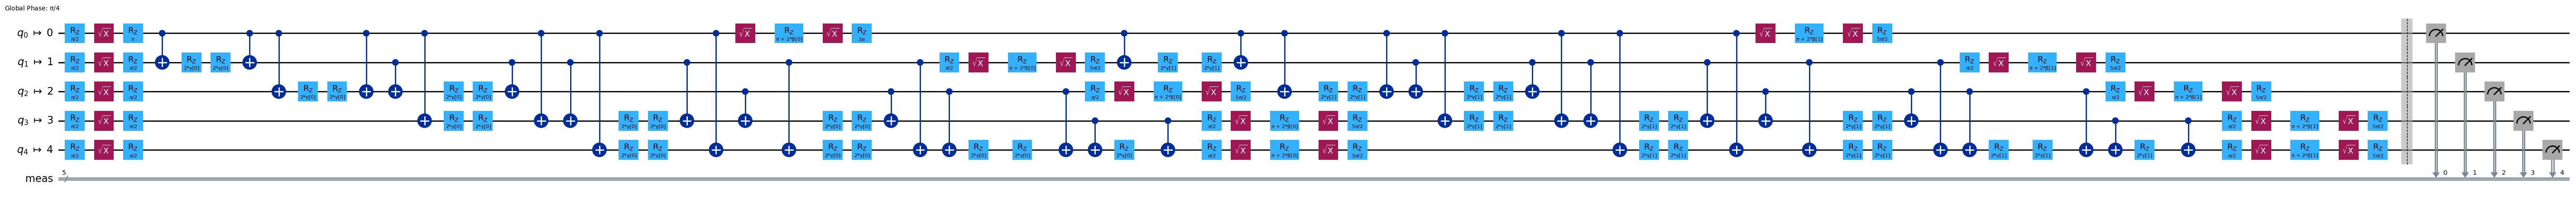

In [12]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

Now we define the initial parameters of our QAOA model.


In [13]:
init_params = np.zeros(2 * layers)

We define and execute an optimization method using the library `scipy`.

In [14]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.2863771362286376
       x: [ 9.958e-01  1.181e+00  3.710e-02  9.495e-01]
    nfev: 47
   maxcv: 0.0


After the optimization routine is executed, we can see how the cost function evolves with the number of iterations to check how the algorithm has converged.

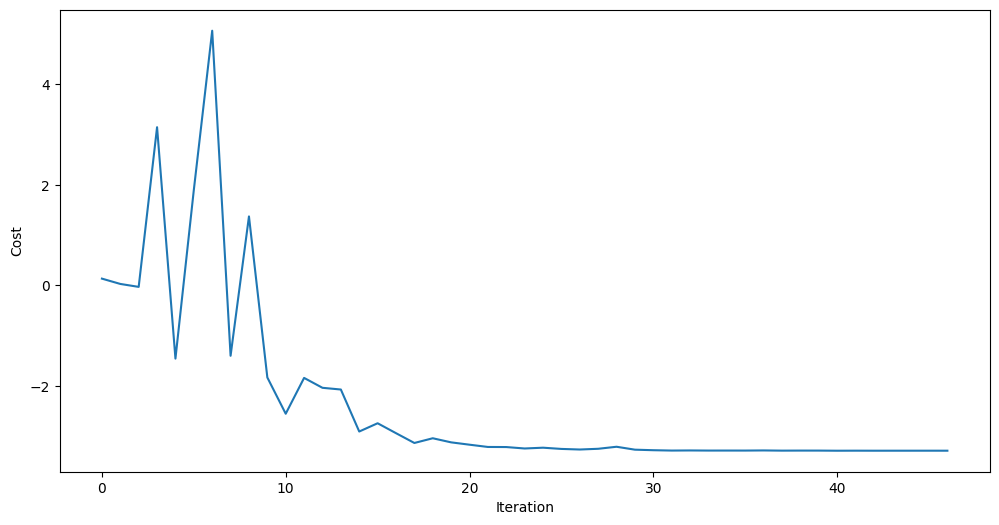

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Nice! As you can see, our circuit has trained quite well, converging to a value that should correspond to the minimum energy of the cost Hamiltonian representing our problem. But are we done yet? How can we be sure that this really is the minimum energy? And equally important, although we might have found the minimum energy, what ground state does it correspond to? Or in other words, what is the actual solution to the Max-cut problem?

# 2.4 Checking our solution <a id="checking"></a>

After training our QAOA circuit using the Estimator primitive to obtain the ground energy of the cost Hamiltonian, we can obtain the ground state by using the Sampler primitive running the circuit with the optimized parameters of the QAOA.

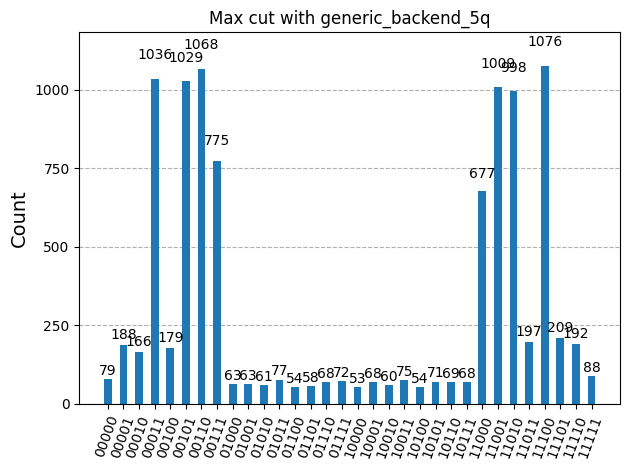

In [16]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

It looks we have 8 different states with significant higher probabilities than the rest, which suggests there might be 8 different ground states. But how can we check that? Luckily for us, this Max-cut problem is not very big in size, so it can still be solved analytically to help us discern if our solution is a good or bad approximation. Let's take a look!

To solve this Max-cut problem analytically, we diagonalize the cost Hamiltonian. Note that this can be done because the size of the problem is not too large; however, the complexity of this problem scales exponentially with the number of nodes (qubits), so the problem becomes intractable for a large number of nodes.

In [17]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -5.0
The number of solutions of the problem is 8
The list of the solutions based on their index is [3, 5, 6, 7, 24, 25, 26, 28]


Great! We obtained 8 solutions as well, so let us now do some post-processing to check if the 8 possible solutions match with ours.

In [18]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']
The QAOA ground states solutions for the Max-cut are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']


Hurray! We've successfully found the right solution of the Max-cut problem using QAOA!

However, it's important to note that these results were obtained using ideal quantum simulators, which do not account for the noise and imperfections present in real quantum hardware. In the next section, we'll explore how QAOA performs when executed on a noisy quantum simulator, which provides a practical view on how noise affects our quantum algorithms.

# 3. Noisy quantum simulator <a id="noisy-simulator"></a>

In this section, we'll run the QAOA algorithm on noisy quantum simulators. These simulators are useful tools that aim to mimic the behaviour and noise of real quantum processors. They allow us to test and evaluate how our quantum algorithms could perform on actual quantum hardware, without consuming valuable quantum resources. Additionally, noisy simulators often run faster since they are executed locally on your machine, avoiding the potential delays and queues associated with cloud-based quantum devices.

However, before we proceed, an important question arises. Which quantum device should I use? This is a key question that is sometimes overlooked. In the following, we'll explore how to choose the most suitable device (or simulator) for running a specific quantum algorithm.

## 3.1 Choosing the backend <a id="choosing-backend"></a>

Here we'll introduce a quantum backend that corresponds to a noisy simulator that mimics the noise of a quantum device.

Let's see which backends are available for you.

In [19]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


If you are using the Open Plan (which is free), you should have `ibm_brisbane`, `ibm_sherbrooke`, and `ibm_torino`. 

We can now create a noisy simulator for each backend you have access to, and see which gates they have.

<div class="alert alert-block alert-warning">
<b>Backend Availability</b>

Depending on your account, you may have different backends available. Use only 3 backends - if possible, use ibm_brisbane, ibm_sherbrooke, and ibm_torino - but if they are not available to you, feel free to use 3 different ones.

In [20]:
# backends=[service.backend("alt_brisbane"),service.backend("alt_kawasaki"),service.backend("alt_torino")]
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]

In [21]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['ecr', 'measure', 'x', 'reset', 'sx', 'id']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['ecr', 'measure', 'x', 'reset', 'sx', 'id']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['cz', 'measure', 'x', 'sx', 'reset', 'id']>)]


Now we transpile the QAOA circuit to the different backends and do a relatively simple analysis of their potential errors.

In the next exercise, you will count the accumulated total error of applying the different quantum circuits to the three backends. We can do that using [`backend.properties()`](https://quantum.cloud.ibm.com/docs/en/guides/get-qpu-information#dynamic-backend-information), [`circuit.data`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.QuantumCircuit) and [`backend.configuration()`](https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.circuit.QuantumCircuit), as they will provide us with the required information to account for the various errors introduced by each instruction.

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 3: Error Counting </b> 

**Your Goal:** Estimate the total error of the quantum circuit. 

In this third exercise you will estimate the total error introduced by all the instructions when executing quantum circuits on different backends by completing the `accululated_errors` function.<br> 
In particular, you'll account for the errors introduced by:

- Single-qubit gates: Depending on the backend, these may include 'rz','x', or 'sx', and you'll have to access each instruction name.
- Two-qubit gates: Depending on the backend, these may include 'cz', 'cx', or 'ecr' gates. You’ll need to identify which gate is used on each backend.
- Readout errors: These contribute a constant error added at the end of the total accumulated error, only on the physical qubits where your circuit is transpiled.

Keep in mind that each qubit has different error rates, so you cannot simply count all operations and multiply by average error values you see on the Compute resources page on IBM Quantum Platform. <br>
While this approximation might yield similar results, the goal of this exercise is to teach you how to access detailed backend information and perform a more accurate estimation of the specific error rates per qubit.

Also, don't count the measure gates as single-qubit gates, as their error is already included in the readout error.

</div>

In [43]:
# Define a function that calculates the accumulated total errors of single and two qubit gates and readout


def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""

    # Initializing quantities
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

        # Defining useful variables
    properties = backend.properties()

    qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:n]


    # ---- TODO : Task 3 ---
    # Goal: Define the following quantities:
    # acc_total_error, acc_two_qubit_error, acc_single_qubit_error, acc_readout_error, single_qubit_gate_count, two_qubit_gate_count

    properties.gate_error(gate="x", qubits=i)

    print(backend.configuration())
    # TODO Define readout error (only for qubits in qubit_layout) using `properties.readout_error`
    acc_readout_error=0
    for q in qubit_layout:
        acc_readout_error+= properties.readout_error(q)
        
    # TODO Define two qubit gates for the different backends using `backend.configuration()`
    if "ecr" in backend.configuration().basis_gates: # TODO
        two_qubit_gate = "ecr"
    elif "cz" in backend.configuration().basis_gates: # TODO
        two_qubit_gate = "cz"
    # TODO Loop over the instructions in `circuit.data` to account for the single and two-qubit errors and single and two qubit gate counts
    for instruction in circuit.data:
        # TODO Count and add errors for one qubit gates
        if len(instruction.qubits) == 1 and instruction.operation.name != "measure":
            single_qubit_gate_count += 1
            qubit_index = circuit.find_bit(instruction.qubits[0]).index
            acc_single_qubit_error += properties.gate_error(instruction.operation.name, qubit_index)
            
        # TODO Count and add errors for two qubit gates
        elif len(instruction.qubits) == 2:
            two_qubit_gate_count += 1
            qubit_indices = [circuit.find_bit(qubit).index for qubit in instruction.qubits]
            acc_two_qubit_error += properties.gate_error(two_qubit_gate, qubit_indices)


    # --- End of TODO ---

    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    results = [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]
    return results

Now, generate `errors_and_counts_list[]` and pass it to the grader.

In [44]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# You can print your results to visualize if they are correct
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 70 gates: 0.207
Accumulated one-qubit error of 457 gates: 0.021
Accumulated readout error: 0.096
Accumulated total error: 0.324

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 70 gates: 0.244
Accumulated one-qubit error of 452 gates: 0.032
Accumulated readout error: 0.086
Accumulated total error: 0.362

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 70 gates: 0.123
Accumulated one-qubit error of 250 gates: 0.035
Accumulated readout error: 0.119
Accumulated total error: 0.277



Let's plot the results.

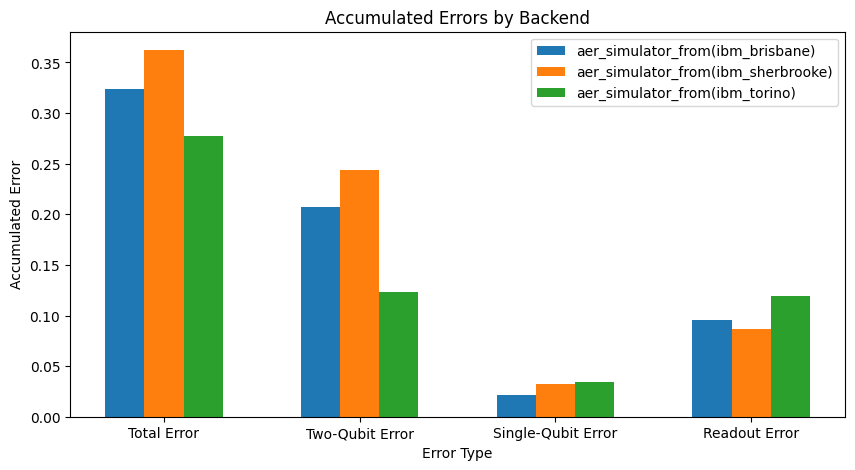

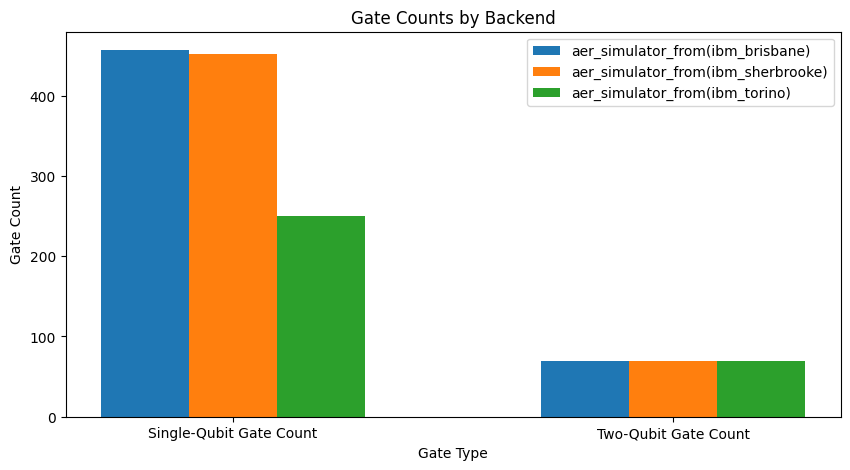

In [45]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [46]:
# Submit your answer using the following code
grade_lab2_ex3(accumulated_errors)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


We have seen that `ibm_torino` has a smaller accumulated error than the other noisy backends. Let's put these results into practice by running the whole QAOA algorithm with the different backends!


<div class="alert alert-block alert-warning">
<b>Warning: 2 minutes needed. Do not skip!</b>

Running the following code will take approximately 2 minutes to execute, and will block this notebook during that time. 

</div>

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.946780532194678
       x: [ 1.048e+00  1.246e+00  4.496e-02  9.712e-01]
    nfev: 79
   maxcv: 0.0


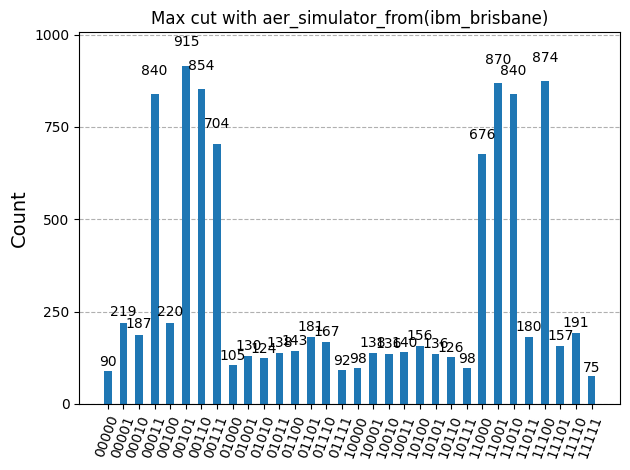

In [47]:
opt_params_list = []
counts_list_backends = []
for noisy_fake_backend, circuit in zip(noisy_fake_backends[:1], qaoa_transpiled_list[:1]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

<div class="alert alert-block alert-warning">
<b>Warning: 8 minutes needed. </b>

Running the following code will take approximately 8 minutes to execute, and will block this notebook during that time. 

If you want to skip this cell, go directly to [Section 4](#transpiler).

</div>

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.8017619823801763
       x: [ 2.049e-01  9.962e-01  9.974e-01 -6.536e-02]
    nfev: 57
   maxcv: 0.0


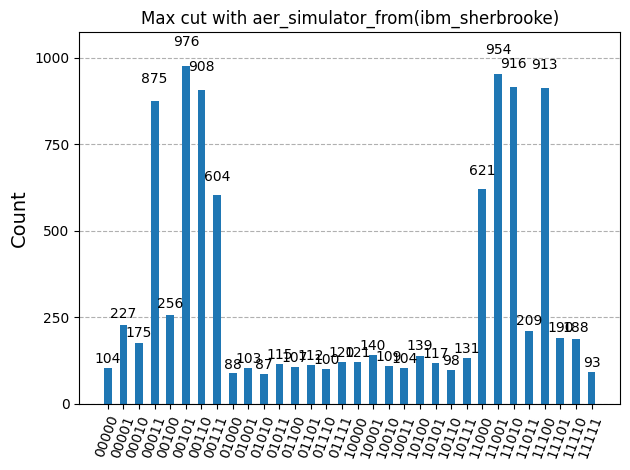

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.16679833201668
       x: [ 1.438e+00 -3.224e-01  8.426e-01  7.982e-02]
    nfev: 59
   maxcv: 0.0


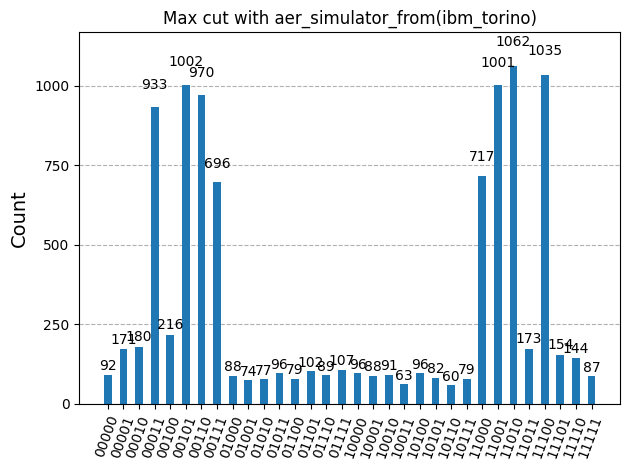

In [48]:
for noisy_fake_backend, circuit in zip(noisy_fake_backends[1:], qaoa_transpiled_list[1:]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

It appears that the three backends give the correct result. However, it looks like the `ibm_torino` backend presents lower noise levels, since the probabilities of measuring a state that is not a solution are lower.

At this point, we can define a metric based on the probability of measuring a correct solution to compare backend performance. Since all three backends have predicted the same 8 solutions as the most probable outcomes, this metric provides a useful way to identify which backend is more reliable in practice.

In [49]:
for noisy_fake_backend, counts_list_backend in zip(noisy_fake_backends, counts_list_backends):
    solutions_counts = [counts_list_backend[key] for key in states_solutions]
    print(
        f"Probability of measuring a solution for {noisy_fake_backend.name} is {float(sum(solutions_counts)/SHOTS)}"
    )

Probability of measuring a solution for aer_simulator_from(ibm_brisbane) is 0.6573
Probability of measuring a solution for aer_simulator_from(ibm_sherbrooke) is 0.6767
Probability of measuring a solution for aer_simulator_from(ibm_torino) is 0.7416


As expected, `ibm_torino` provides us with the highest probability of measuring a solution. This confirms that our earlier error estimation analysis was correct in predicting which backend would execute the algorithm with minimum errors. To further understand the impact of noise, we can also compare these probabilities to that of the `GenericBackend`, which simulates an ideal, noise-free scenario.

In [50]:
solutions_counts_noiseless = [counts_list[key] for key in states_solutions]
print(
    f"Probability of measuring a solution for {generic_backend.name} is {float(sum(solutions_counts_noiseless)/SHOTS)}"
)

Probability of measuring a solution for generic_backend_5q is 0.7668


The probability of measuring a correct solution on the noise-free `GenericBackend` is, as expected, higher than on the noisy backends. However, the difference is not that big. This highlights an important point. Even with current noisy quantum computers, as long as we are careful and smart in our circuit design and use the right tools, we can still solve many problems with a good degree of accuracy!

# 3.2 Estimating errors using NEAT <a id="neat"></a>

The error estimation we have done above is a nice approximation of how noisy a device is going to be. Qiskit offers us another alternative, the Noisy Estimator Analyzer Tool (NEAT). NEAT is a function designed to help users understand and predict the performance of quantum estimation tasks, particularly when using the Estimator primitive. It leverages the `qiskit-aer` simulator to perform both ideal (noiseless) and noisy simulations of quantum circuits. 

A key feature of NEAT is its ability to simulate Clifford circuits efficiently. For non-Clifford circuits, NEAT can automatically convert them to their nearest Clifford equivalents that approximate their quantum state. This makes NEAT especially useful for performing a noise analysis of our quantum circuits before running them on real quantum hardware. However, this approximation introduces limitations, since Clifford equivalents do not perfectly replicate the behavior of non-Clifford circuits, and therefore the simulation may lose accuracy in certain cases.

From a practical point of view, one way to use NEAT is to simulate a quantum circuit in a noisy and noiseless scenario measuring an observable whose expectation value is exactly 1 in the ideal (noiseless) case. In this setup, any deviation from 1 in the noisy simulation directly reflects the impact of noise on the circuit. An easy way to ensure that the observable meets the requirements is choosing:
$$
\hat{O}=|\psi\rangle\langle \psi|, \quad \textrm{since} \quad \langle \psi |\hat{O}|\psi \rangle=1, 
$$
where $|\psi\rangle$ is the quantum state generated by the circuit we want to simulate. 

Let's apply NEAT to our different noisy backends to see how they perform.

In [51]:
results = []
for backend, opt_params in zip(noisy_fake_backends, opt_params_list):
    print(f"\nRunning on backend: {backend.name}")

    # Prepare the QAOA circuit with optimized parameters
    qaoa_neat = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
    qc = qaoa_neat.assign_parameters(opt_params)

    # Transpile the circuit
    qc_transpiled = generate_preset_pass_manager(
        optimization_level=3,
        basis_gates=backend.configuration().basis_gates[:n],
        seed_transpiler=seed,
    ).run(qc)
    # Use cost Hamiltonian as observable for Cliffordization
    obs = cost_hamiltonian
    analyzer = Neat(backend)
    clifford_pub = analyzer.to_clifford([(qc_transpiled, obs)])[0]

    # Construct observable from Clifford circuit
    state_clifford = Statevector.from_instruction(clifford_pub.circuit)
    obs_clifford = SparsePauliOp.from_operator(Operator(DensityMatrix(state_clifford).data))

    # Apply layout
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    isa_qc = pm.run(clifford_pub.circuit)
    isa_obs = obs_clifford.apply_layout(isa_qc.layout)

    # Prepare pubs and simulate
    pubs = [(isa_qc, isa_obs)]
    result_noiseless = (
        analyzer.ideal_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )
    noisy_results = (
        analyzer.noisy_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )

    # Store and print results
    results.append({"backend": backend.name, "noiseless": result_noiseless, "noisy": noisy_results})
    print(f"Ideal results on {backend.name}:\n{result_noiseless:.3f}")
    print(f"Noisy results on {backend.name}:\n{noisy_results:.3f}")


Running on backend: aer_simulator_from(ibm_brisbane)
Ideal results on aer_simulator_from(ibm_brisbane):
1.000
Noisy results on aer_simulator_from(ibm_brisbane):
0.799

Running on backend: aer_simulator_from(ibm_sherbrooke)
Ideal results on aer_simulator_from(ibm_sherbrooke):
1.000
Noisy results on aer_simulator_from(ibm_sherbrooke):
0.628

Running on backend: aer_simulator_from(ibm_torino)
Ideal results on aer_simulator_from(ibm_torino):
1.000
Noisy results on aer_simulator_from(ibm_torino):
0.769


Using the NEAT tool, we can observe how the expectation value in a noisy simulation deviates from the ideal value of 1, in a way that agrees with the noise analysis performed in [Section 3.1](#choosing-backend). 

However, as mentioned before, we should be aware that here we are analyzing Cliffordized versions of the quantum circuits, which means that some gates have been transformed to ensure the circuit belongs to the Clifford group. As a result, while the transformed circuit is similar, it does not produce exactly the same quantum state. This means that NEAT provides a useful approximation of how much noise a circuit might accumulate on a given backend, but it doesn't offer exact predictions or guarantees. This is important to keep in mind!

# 4. Transpiler <a id="transpiler"></a>

The transpiler is one of the most important and useful tools for running quantum circuits on real quantum hardware. It serves as a bridge between the abstract, idealized version of a quantum circuit and the physical implementation on the actual quantum device. When you design a circuit, you typically use virtual qubits and ideal gates without considering the hardware's specific limitations. The transpiler translates this high-level circuit into a version that can be implemented on a real quantum computer, using only the physical qubit's gate operations available on the device.

For example, suppose your circuit includes a CNOT gate between virtual qubits 0 and 1. On a real device, these two qubits might not be directly connected. In such cases, the transpiler inserts a series of SWAP gates to move the quantum states to physically adjacent qubits, enabling the CNOT operation. Alternatively, the transpiler might find a more efficient qubit mapping, such that virtual qubits 0 and 1 are reassigned to physical qubits that are directly connected - for example, qubits 3 and 4, hence avoiding the need for additional SWAP gates.

Up to now we have been using the transpiler implicitly when executing the pass manager in `generate_preset_pass_manager`. However, now we will focus on understanding it better and leveraging it to its fullest for better circuit design.

# 4.1 Minimizing the two-qubit gates <a id="min-two-qubit"></a>

One of the most important tasks of a quantum transpiler is to determine an optimal qubit layout for executing a quantum circuit. This involves finding the best mapping between the circuit's virtual qubits and the device's physical qubits. To do so, there are a few things to take into consideration. 

First, the transpiler must check for all the two-qubit gates in the circuit and ensure that the selected physical qubits are connected in a way that enables these operations and reduces the necessity of using additional SWAP gates. This requires inspecting the coupling map, which shows how physical qubits are connected.

First we will perform a transpilation of the quantum circuit to a layout in the quantum computer that minimizes the number of two-qubit gates, since that will be the main source of error.

In particular, we will consider the `ibm_brisbane` backend, where, as shown in [Section 3.1](#choosing-backend), two-qubit gate errors account for the majority of the total accumulated error.

In [52]:
# We select the `ibm_brisbane` backend
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# We print the results
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[62, 72], [81, 72], [62, 61], [62, 63]]
The errors introduced by each of the two-qubit operations are:
 [0.007, 0.004, 0.011, 0.007]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.198, 0.058, 0.148, 0.098]
The repetitions of each one of the two-qubit operations is:
 [29, 13, 13, 15]
The number of two-qubit operations in total:
 70
The total accumulated error by two-qubit operations is:
 0.503


# 4.2 Find the optimal layout <a id="opt-layout"></a>

Next, the transpiler must choose the "best" physical qubits that fulfill the connectivity constraints. However, defining "best" in this context is a challenging task, as it depends on multiple hardware-specific metrics such as coherence times ($T_1$, $T_2$), single-qubit gate error rates, readout errors, and two-qubit gate error rates. Optimizing across all these metrics at the same time is not straightforward, and it often involves trade-offs.

In this exercise, we simplify the problem by focusing on two criteria: 
1. The selected qubits must satisfy the required connectivity given by the transpiler
2. We choose the qubits with the lowest two-qubit gate error rates

As discussed in [Section 3.1](#choosing-backend), two-qubit gate errors are typically the predominant source of noise in many quantum devices.

In this exercise, look for a different qubit configuration (layout) that gives you a smaller total accumulated error when accounting only for the two-qubit gates. However, this may be too easy, and since we're approaching the end of the lab, you can increase the difficulty by looking for all the possible layouts that offer a smaller total accumulated error of two-qubit gates operations.

Building the following graph will help you visualize the possible configurations, and will also serve to find all the layouts that fulfill the desired conditions.

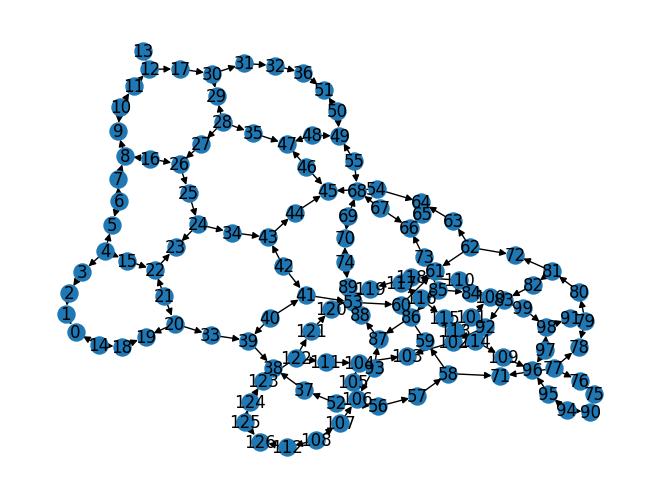

In [53]:
# We build a graph with the connectivity constraints of our backend that includes the two-qubit gate errors as weights in the edges
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(
                gate=two_qubit_gate, qubits=(edge[0], edge[1])
            ),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)

Also take into account that we have to look for layouts that have the connectivity allowing for the gates in `pair_list`, which can be converted to a more interpretable list using `logical_pair_list`:


In [54]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """Remap node labels to a new sequence starting from 0 based on their order in original_labels."""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")

Physical qubit layout list:
 [72, 62, 81, 61, 63]

Original two-qubit gates list:
 [[62, 72], [81, 72], [62, 61], [62, 63]]

Remapped two-qubit gates list (in logical qubits):
 [[1, 0], [2, 0], [1, 3], [1, 4]]



<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 4: Good Mapping </b> 

**Your Goal:** Find all the good qubit layouts. 

In this fourth exercise you will find ALL the possible qubit layouts that have a smaller two-qubit gate accumulated error than the layout transpilation of the above, whose value is stored in the variable `acc_two_qubit_error`. This problem can be reformulated as a graph problem in which you need to find ALL the paths in the graph above which the total edge weights sum to less than the specified threshold and that have the same connectivity of that in `logical_pair_list`.


</div>

<div class="alert alert-block alert-warning">
<b>Warning: Don't try to solve it by brute force!</b>

If you try a brute force approach, it might take hours of computation, as there are too many paths. Instead, restrict the search to only the paths that have the same connectivity of `logical_pair_list`, which are <100, and your computation will take less than 1 second.
</div>

</div>

<div class="alert alert-info">
<details>
    <summary> <b>Hint</b> 💡: (Click to expand)</summary>
    
The proposed workflow for this exercise is:

1. Start from each node in the graph and iteratively build paths by extending them one step at a time. 

2. At each step, use the `logical_pair_list` to decide which node in the current path to expand from.

3. Depending on whether the node we are expanding from in the path corresponds to the control or the target qubit (based on `logical_pair_list`), we choose how to access its neighbors:

    3.1 If it's the control qubit, we use directed edges (`graph.neighbors`).

    3.2 If it's the target qubit, we use undirected edges (`graph.neighbors_undirected`).

4. As you extend each path, calculate the cumulative weight by multiplying the edge weight (`graph.get_edge_data(edge_1,edge_2)`) by the corresponding value in `two_qubit_ops_list`. Note that if you are using the undirected neighbors, you should use `graph.get_edge_data(edge_2,edge_1)`.

5. When the path is complete, i.e., when it gets to the length of the `two_qubit_ops_list`, check to only keep paths whose total weight stays below the threshold.

</details>

</div>

You might find these functions useful for the next exercise: [rx.PyDiGraph.neighbors](https://www.rustworkx.org/dev/apiref/rustworkx.PyDiGraph.neighbors.html), [rx.PyDiGraph.neighbors_undirected](https://www.rustworkx.org/dev/apiref/rustworkx.PyDiGraph.neighbors_undirected.html), and [rx.PyDiGraph.has_edge](https://www.rustworkx.org/apiref/rustworkx.PyDiGraph.has_edge.html), which were used in the code below.

Additionally, you might find [rx.PyDiGraph.get_edge_data](https://www.rustworkx.org/apiref/rustworkx.PyDiGraph.get_edge_data.html) particularly useful. It allows you to obtain the two-qubit gate error associated with each interaction in the graph.

In [86]:
def find_paths_with_weight_sum_below_threshold(
    graph: rx.PyDiGraph,
    threshold: float,
    two_qubit_ops_list: list[int],
    logical_pair_list: list[list[int]],
) -> tuple[list[list[int]], list[float]]:
    """Find all valid paths through a graph whose weighted sum is below a given threshold."""
    valid_paths = []
    valid_weights = []

    # Task 4 ---
    # Goal: Find all valid paths through a graph such that the total weighted sum of the path is below a given threshold.

    # Iterate over all possible starting nodes in the graph
    for start_node in range(graph.num_nodes()):
        # Initialize the list of paths with a single-node path starting from the current node
        paths = [[start_node]]
        # Initialize the corresponding weights for each path (starting with 0)
        weights = [0]
        # Iterate through each step in the sequence of two-qubit operations
        for i in range(len(two_qubit_ops_list)):
            new_paths = []    
            new_weights = []  
            # Go through each current path and its weight
            for path, weight in zip(paths, weights):
                # We need to determine which node in the current path is involved in the next logical operation, so we can expand from it.
                # Determine which node in the path we are going to expand from using logical_pair_list
                if logical_pair_list[i][0] < logical_pair_list[i][1]:
                    index_of_expanding_node = logical_pair_list[i][0] # control qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists
                        if neighbor not in path and graph.has_edge(node_to_expand_from, neighbor):
                            # Calculate the edge weight, scaled by the number of times the gate is applied which is in two_qubit_ops_list
                            
                            #### TODO ####
                            
                            # For undirected neighbors, check which direction the edge exists
                            if graph.has_edge(neighbor, node_to_expand_from):
                                edge_weight = graph.get_edge_data(neighbor, node_to_expand_from) * two_qubit_ops_list[i]
                            elif graph.has_edge(node_to_expand_from, neighbor):
                                edge_weight = graph.get_edge_data(node_to_expand_from, neighbor) * two_qubit_ops_list[i]
                            
                            #### End of TODO ####
                            
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
                else:
                    index_of_expanding_node = logical_pair_list[i][1] # target qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all undirected_neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors_undirected(node_to_expand_from):
                        # Ensure we don't revisit nodes
                        if neighbor not in path:
                            # Calculate the edge weight, scaled by the number of times the gate is applied which is in two_qubit_ops_list
                            
                            #### TODO ####
                            
                            edge_weight = graph.get_edge_data(node_to_expand_from, neighbor) * two_qubit_ops_list[i]
                            
                            #### End of TODO ####
                            
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
            # Update paths and weights for the next iteration
            paths = new_paths
            weights = new_weights

        # After building all possible paths, filter those under the threshold
        for path, weight in zip(paths, weights):

            #### TODO: Complete the condition for `if` ####
            
            if(weight <= threshold): 
                valid_paths.append(path)
                valid_weights.append(weight)

            #### End of TODO ####
            
    # --- End of TODO ---

    return valid_paths, valid_weights


threshold = acc_two_qubit_error

valid_paths, valid_weights = find_paths_with_weight_sum_below_threshold(
    graph, threshold, two_qubit_ops_list, logical_pair_list
)
# Note that there could be no other paths with smaller errors
if valid_weights:
    minimum_weight_index = valid_weights.index(min(valid_weights))
    opt_layout = valid_paths[minimum_weight_index]
else:
    minimum_weight_index = None
    opt_layout = layout_list
print(f"We found {len(valid_paths)} valid paths")

NoEdgeBetweenNodes: No edge found between nodes

In [84]:
init_layout = Layout({q: phys for q, phys in zip(qaoa_circuit.qubits, opt_layout)})
pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    initial_layout=init_layout,
    layout_method="sabre",
)

circuit_opt = pm.run(qaoa_circuit)

(
    acc_total_error_opt,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_opt, noisy_fake_backend)

print(
    f"The path with smaller errors in its two-qubit gates is: {opt_layout} \n",
    f"With total accumulated error of {acc_total_error_opt:.3f}",
)

The path with smaller errors in its two-qubit gates is: [5, 4, 6, 15, 3] 
 With total accumulated error of 0.230


In [85]:
# Submit your answer using the following code
grade_lab2_ex4(find_paths_with_weight_sum_below_threshold)

NoEdgeBetweenNodes: No edge found between nodes

Well done, you've completed the most complicated part of the work. Now all of the found combinations are better than the trivial threshold.

To this point, we've seen how optimizing the layout of qubits can significantly reduce the accumulated error from two-qubit gates. But can you imagine having to do this manually every time we want to run a quantum circuit on real hardware? That would be incredibly tedious. But don't worry - the transpiler can handle this task for us. By using one of the `layout_methods` provided, it smartly selects a layout of qubits that satisfies the connectivity necessities of our circuit, while also aiming to minimize the number of two-qubit gates.

In particular, we will use the `sabre` method, which is a stochastic technique that aims to minimize the number of SWAP gates. To make the most of it, we'll perform a sweep over different values of the transpiler seed. This allows us to explore multiple layout configurations and choose the one that minimizes the two-qubit error rate, as we wanted. Note that here we could have selected to minimize the circuit depth or the number of two-qubit gates, the readout error, or any other metric we wanted to use.

<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b>Exercise 5: Best Mapping </b> 

**Your Goal:** Use the transpiler to find the optimal layout.

In this fifth exercise you will use the `sabre` `layout_method` to identify the layout that has the lowest two-qubit gate accumulated error. <br>

To do so, perform a sweep over the `seed_transpiler` values from 0 to 500 and use the `generate_preset_pass_manager` with `optimization_level=3` to select the best layout. Remember you can count the accumulated error of the two-qubit gates and the two-qubit gate number using the `two_qubit_gate_errors_per_circuit_layout` function.

In [ ]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    # First we loop over 500 seeds and transpile the circuit
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        # ---- TODO : Task 5 ---
        # Goal: Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend looping from 0 to 500

        # TODO Use the `two_qubit_gate_errors_per_circuit_layout` function to count for the error of the transpile circuit

        # TODO Check if the error accounted above is smaller than min_err_acc_seed_loop. If so, assign the variables that this function returns

        # --- End of TODO ---

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )

In [ ]:
(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qaoa_circuit, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

In [ ]:
# Submit your answer using the following code
grade_lab2_ex5(finding_best_seed)

Next, we sample the QAOA circuit with these circuits to highlight the importance of good transpilation.

<div class="alert alert-block alert-warning">
<b>Warning: 5 minutes needed.</b>

Running the following code will take approximately 5 minutes to execute, and will block this notebook during that time.  You can skip to the next cell.

</div>

In [ ]:
counts_list_transpiled_circuits = []
circuit_transpiled_list = [circuit_transpiled, circuit_opt_seed_loop]
opt_params_list_transpiled_circuits = []
for circuit in circuit_transpiled_list:
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list_transpiled_circuits.append(opt_params)
    counts_list_transpiled_circuit = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_transpiled_circuits.append(counts_list_transpiled_circuits)
    solutions_counts = [counts_list_transpiled_circuit[key] for key in states_solutions]
    print(f"Probability of measuring a solution for is {float(sum(solutions_counts)/SHOTS)}")

In the following, remember to use the `sabre` layout method and loop over different seeds to minimize a specific metric - such as two-qubit gate counts, depth, or accumulated error - in order to maximize performance.

In this section we have seen that transpilation is a key step in preparing quantum circuits to be executed on real hardware. Since different devices have different layouts and gate sets, a good transpiler helps to adapt your circuit to fit the hardware while trying to keep things like quantum depth and error rates low, thus achieving better performance from your quantum algorithms.

# 5. Error Mitigation (EM) <a id="em"></a>

One of the main areas of research to address the inevitable noise in quantum devices is **error mitigation (EM)**. EM consists of a set of intelligent techniques designed to reduce the impact of noise without requiring complex error correction codes or additional qubits, resources that remain limited in today's quantum hardware. Instead of correcting errors as they occur, EM uses strategies such as loop repetition, calibration-based adjustments, and classical post-processing to improve the quality of the final results, leading to an improved performance in our quantum algorithms.

This approach is especially valuable for current devices, which are small- to medium-scale and inherently noisy. Fully fault-tolerant quantum computing is still beyond our reach, but EM offers a practical way to take full advantage of the devices we have now.
EM integrates naturally with hybrid quantum-classical algorithms, those that alternate between quantum and classical computation, such as:

- Variational Quantum Eigensolver (VQE),
- Quantum Approximate Optimization Algorithm (QAOA), and
- Quantum-enhanced machine learning models.

These types of algorithms are especially sensitive to noise, and EM can greatly improve their reliability and accuracy.

Remarkably, EM does not eliminate all imperfections, but it refines the result enough to make it useful and actionable. It is a tool for narrowing the gap between noisy quantum results and meaningful insights, paving the way for practical quantum applications even before large-scale error-correcting machines become a reality.

There are several well-established techniques used in EM, each tailored to address different types of noise and imperfections in quantum computations.

One of the most widely used methods is Zero Noise Extrapolation (ZNE). In this approach, the same quantum circuit is executed multiple times with deliberately increased noise levels. Then, mathematical extrapolation techniques are applied to estimate what the outcome would have been in the absence of noise. This method was introduced by [Temme et al. in 2017](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509).



## 5.1 Zero Noise Extrapolation (ZNE) <a id="zne"></a>

ZNE is a powerful quantum error mitigation technique designed to reduce the impact of noise in quantum circuits without requiring additional qubits or full error correction. The process consists of three essential stages: noise amplification, execution at various noise levels, and classical extrapolation back to the zero-noise limit.


### Noise amplification

The first stage, Noise Amplification, lies at the heart of ZNE. The idea is to run the quantum circuit in versions that have more noise than usual, but in a controlled and reversible way. By comparing how the output changes as noise increases, it becomes possible to infer what the result would be with no noise at all. This is typically achieved using a technique called circuit folding.

Circuit folding artificially increases the noise in a quantum computation by inserting additional gates that, in theory, do not alter the logical outcome. These additional gates are the adjoint (inverse) operations of previously applied gates. For example, a unitary operation $U$ can be transformed into  $ U \cdot U^\dagger \cdot U$, which logically still computes $U$, but takes longer to execute, thus being exposed to more noise from the hardware.


There are two common types of folding: **Global Folding** and **Local Folding**. 


#### Global folding



In Global folding, the entire quantum circuit is folded as a single block. This means the full unitary operation $U$ that the circuit represents is wrapped with its adjoint operation, yielding the transformation:

$$U \rightarrow U \cdot U^\dagger \cdot U$$

This global transformation is logically equivalent to the original circuit, since $U^\dagger \cdot U$ is the identity operation. However, because the circuit is now longer and includes more gate operations, it becomes more susceptible to environmental noise and hardware imperfections.

Global folding is particularly useful for quickly applying a uniform increase in noise across the full circuit. It is straightforward to implement and does not require knowledge of the internal structure of the circuit. As such, it serves as a coarse-grained approach to noise amplification, suitable for general-purpose extrapolation when fine control is not needed.


<a id="exercise_6a"></a>

<div class="alert alert-block alert-success">
<b>Exercise 6a: Global Folding</b>

**Your Goal:** Implement global folding on the quantum circuits.

In this part of Exercise 6 (Section a), you will create a function that applies global folding to any quantum circuit. Your implementation should allow evaluation of the circuit at different noise scaling factors, which simulate increased noise levels while preserving the circuit's logical output. The noise scaling factor represents the number of times a circuit $U$ or $U^\dagger$ is applied, with 1 being the non-folding case.

</div>

In [ ]:
def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Apply global circuit folding for Zero Noise Extrapolation (ZNE)."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")
    # We define the number of times we are going to "fold" the circuit
    n_repeat = (scale_factor - 1) // 2
    folded_circuit = QuantumCircuit(circuit.qubits, circuit.clbits)

    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """Remove all measurements from a quantum circuit."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr in qc.data:
            if instr.operation.name != "measure":
                clean_qc.append(instr.operation, instr.qubits)
        return clean_qc

    # Make a quantum circuit as a U (Unitary) by removing measurements, since measurements are not unitary
    clean_circuit = remove_all_measurements(circuit)

    # ---- TODO : Task 6a ---
    # Implement the global circuit folding. Use `QuantumCircuit.append` and `QuantumCircuit.inverse` functions
    # add U^† (inverse of clean_circuit) then U(clean_circuit) to the main circuit (folded_circuit)

    # --- End of TODO --

    return folded_circuit

In [ ]:
# Submit your answer using the following code
grade_lab2_ex6a(fold_global_circuit)

#### Local Folding


Local folding focuses on selectively increasing the noise in specific parts of the quantum circuit, usually around the most error-prone gates or subcircuits. Instead of folding the entire circuit as a block, this method focuses on individual quantum gates or groups of gates. This provides greater control and more precise calibration of the noise amplification process. Its operation is to take from the quantum circuit each quantum gate $G$. We can apply local folding by wrapping it with its inverse operation as follows:

$$ G \rightarrow G \cdot G^\dagger \cdot G $$

This transformation logically cancels the inserted $G^\dagger \cdot G$ pair, leaving the computation unchanged. However, the execution now involves three times as many gate operations, thereby increasing the local noise exposure. This makes it ideal for simulating different noise levels selectively and systematically.


<a id="exercise_6b"></a>

<div class="alert alert-block alert-success">
<b>Exercise 6b: Local Folding</b>


**Your Goal:** Implement local folding on quantum circuits.

In this second part of Exercise 6 (Section b), your task is to write a function that applies local folding to a quantum circuit. Unlike global folding, this method focuses on individual gates and selectively folds them to amplify noise in specific areas of the circuit.  The function should allow flexible control of the gates being folded (for example, we cannot fold a measurement gate) and their evaluation at different noise amplification scales.
</div>

In [ ]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Performs Zero-Noise Folding at the level of individual circuit instructions."""

    if scale_factor % 2 == 0:
        raise ValueError("scale must be an odd positive integer (1, 3, 5, ...)")
    # We define the number of times we are going to "fold" each instruction
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.qubits, circuit.clbits)

    if scale_factor == 1:
        return circuit
    else:
        for instrction in circuit.data:
        # ---- TODO : Task 6b ---
        # Implement the local circuit folding. Don't fold measurement gates!
        # 
            

        # --- End of TODO ---

    return qc_folded

In [ ]:
# Submit your answer using the following code
grade_lab2_ex6b(fold_local_circuit)

### Extrapolation


After amplifying the noise through folding, the quantum circuit is executed multiple times at different noise levels. Finally, in the third step, **Extrapolation**, the results from the noisy runs are post-processed using classical fitting methods, such as linear, polynomial, or exponential extrapolation, to estimate what the outcome would be in a hypothetical zero-noise scenario. Through this pipeline, ZNE helps recover higher-fidelity results from current noisy quantum hardware, making it a valuable tool in the near-term quantum computing landscape.


Now, we will integrate ZNE into the execution of a QAOA circuit, improving the accuracy of results on noisy quantum hardware.

In [ ]:
def basic_zne(
    circuit,
    scales,
    backend,
    opt_params,
    observable,
):
    """Basic Zero Noise Extrapolation (ZNE) loop using local folding."""

    exp_vals = []
    xdata = np.array(scales)
    estimator = Estimator(mode=backend)

    for scale in scales:
        # Apply local folding
        folded = fold_local_circuit(circuit, scale)

        # Transpile for the backend
        basis_gates = backend.target.operation_names
        transpiled_folded = generate_preset_pass_manager(
            basis_gates=basis_gates, optimization_level=0, seed_transpiler=seed
        ).run(folded)
        pub = (
            transpiled_folded,
            observable.apply_layout(circuit.layout),
            opt_params,
        )
        # Evaluate the expectation value
        job = estimator.run([pub])
        results = job.result()[0]
        exp_vals.append(results.data.evs)

    return xdata, exp_vals, pub

In [ ]:
scales = [1, 3, 5, 7, 9, 11, 13]
xdata, ydata, pub = basic_zne(
    qaoa_circuit_transpiled,
    scales,
    noisy_fake_backend,
    opt_params_list[num_backend],
    cost_hamiltonian,
)

To validate and analyze the results of the ZNE we just implemented, we can apply three types of extrapolation methods: linear, polynomial, and exponential. These approaches help estimate the circuit's output in the zero-noise limit based on the data collected at higher noise levels. To illustrate how this can be done, consider the following example code:

In [ ]:
methods = ["linear", "quadratic", "exponential"]

for method in methods:
    print(f"\n Extrapolation Method: {method.upper()}")

    # Perform the extrapolation
    zero_val, fitted_vals, fit_params, fit_fn = zne_method(method=method, xdata=xdata, ydata=ydata)

    # Print the extrapolated expectation value
    print(f"⟨Z⟩ (ZNE Estimate): {zero_val:.3f}")

    # Plot the results
    plot_zne(xdata, fitted_vals, zero_val, fit_fn, fit_params, method)

# Conclusions <a id="conclusions"></a>

Good job completing Lab 2! 

In this lab we explored the various sources of noise that can affect your quantum circuit, and - more importantly - the dedicated tools we can use to *cut through the noise*. With these tools at hand, you're now well-equipped to tackle any of your ongoing quantum algorithms and execute them on real quantum hardware. Remember, the key steps to follow are:

- **Choose the right hardware** that is well-suited for your circuit.
- **Use the transpiler** to select the best possible layout and minimize the number of two-qubit gates and other metrics.
- **Apply error mitigation and suppression** to further reduce the impact of noise and improve the performance.

Keep that in mind and you are all set to tackle your quantum challenges ahead!

That's all, folks! Or is it?

In [ ]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

# Bonus challenge: Scaling it up! <a id="bonus"></a>

As a bonus, we've included a more complicated version of this problem, in which you'll implement the Max-cut problem on IBM quantum hardware. This is your chance to put everything you've learned into practice, including the error mitigation techniques!

### The problem

In [ ]:
# We define the number of nodes:
n_ext = 7
# We define the graph
graph_ext = rx.PyGraph()
graph_ext.add_nodes_from(np.arange(0, n_ext, 1))
generic_backend_ext = GenericBackendV2(n_ext, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph_ext.add_edges_from(
    [(edge[0], edge[1], weights) for edge in generic_backend_ext.coupling_map][:-7]
)
draw_graph(graph_ext, node_size=200, with_labels=True, width=1)
max_cut_paulis_ext = graph_to_Pauli(graph_ext)
cost_hamiltonian_ext = SparsePauliOp.from_list(max_cut_paulis_ext)
pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend_ext, seed_transpiler=seed
)
layers = 2
init_params = np.zeros(2 * layers)
qaoa_circuit_ext = QAOAAnsatz(cost_operator=cost_hamiltonian_ext, reps=layers)
qaoa_circuit_ext.measure_all()
qaoa_circuit_ext_transpiled = pm.run(qaoa_circuit_ext)

### Choose the backend

In [ ]:
qaoa_circuit_transpiled_ext_list = []
acc_error_list = []


for backend_hw in real_backends:

    pm = generate_preset_pass_manager(
        optimization_level=3, backend=backend_hw, seed_transpiler=seed
    )
    qaoa_circuit_transpiled_ext = pm.run([qaoa_circuit_ext])[0]
    qaoa_circuit_transpiled_ext_list.append(qaoa_circuit_transpiled_ext)

    # ---- TODO : Bonus Task ---

    # Use the accumulated_errors function, `backend_hw` and `qaoa_circuit_transpiled_ext` and get the [0] value
    acc_error = 

    # --- End of TODO ---

    acc_error_list.append(acc_error)
# We choose the backend with smallest error
best_backend_ext = real_backends[acc_error_list.index(min(acc_error_list))]
print(
    f"The backend {best_backend_ext.name} has the circuit with the smallest accumulated error: {min(acc_error_list):.3f}"
)

### We optimize the layout and minimize the accumulated error

In [ ]:
circuit_ext_opt_seed, best_seed_transpiler, min_err_acc_seed, _ = finding_best_seed(
    qaoa_circuit_ext, best_backend_ext
)
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed:.3f}")

### We execute the circuit on simulator

First, we must optimize the parameters of this QAOA problem. 

In [ ]:
best_backend_sim = AerSimulator.from_backend(best_backend_ext, seed_simulator=seed)
result_qaoa_sim, objective_func_vals_sim = train_qaoa(
    init_params, circuit_ext_opt_seed, cost_hamiltonian_ext, best_backend_sim
)

Now we can sample from the QAOA circuit.

In [ ]:
opt_params_sim = result_qaoa_sim.x
counts_list_sim = sample_qaoa(opt_params_sim, circuit_ext_opt_seed, best_backend_sim)

# Checking the results

In [ ]:
eigenvalues_ext, eigenvectors_ext = np.linalg.eig(cost_hamiltonian_ext)
ground_energy_ext = min(eigenvalues_ext).real
num_solutions_ext = eigenvalues_ext.tolist().count(ground_energy_ext)
index_solutions_ext = np.where(eigenvalues_ext == ground_energy_ext)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy_ext}")
print(f"The number of solutions of the problem is {num_solutions_ext}")
print(f"The list of the solutions based on their index is {index_solutions_ext}")

states_solutions_ext = decimal_to_binary(index_solutions_ext, n_ext)
# Sort the dictionary items by their counts in descending order
sorted_states_sim = sorted(counts_list_sim.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states_sim = sorted_states_sim[:num_solutions_ext]
# Extract only the states keys from the top entries
qaoa_ground_states_sim = sorted([state for state, count in top_states_sim])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions_ext}")
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_sim} for {best_backend_sim.name}"
)

# Running on Hardware


<a id="Warning_1"></a>

<div class="alert alert-block alert-warning">
  <b>Resource limit:</b> 

When running the section below, you will execute the above problem on real hardware, which could consume approximately 2-3 minutes of the your Open Plan allotment. Please proceed only if you're comfortable with this potential usage. Also, please try to maintain these settings if possible, to make sure you don't use too much time. 
</div>

Finally we can execute the problem on hardware, and compare the results.


### Estimator

We will not train the QAOA circuit on hardware, as it will consume a lot of your Open Plan allotment. Instead, we'll execute the estimator with the optimized parameters and will apply error mitigation techniques later to see how we can improve the results.

First we compute the ground state energy on hardware without error mitigation.

In [ ]:
# ---- TODO : Bonus Task ---

# Based on previous section, choose the best backend for executing the code on hardware
best_backend_hw = 

# --- End of TODO ---

options = EstimatorOptions(default_shots=100000)
estimator = Estimator(mode=best_backend_hw, options=options)
ground_energy_ext_hw = cost_func_estimator(
    opt_params_sim, circuit_ext_opt_seed, cost_hamiltonian_ext, estimator
)
print(
    f"The ground energy of the QAOA circuit executed on {best_backend_hw.name} without EM is: {ground_energy_ext_hw}"
)

Now we apply different error mitigation and error suppression techniques.
The different techniques we'll apply are:

- **Dynamical decoupling**: this error suppression technique involves applying a sequence of control pulses to idle qubits to cancel out unwanted interactions and coherent errors. It helps preserve quantum coherence by effectively "decoupling" the system from noise sources over time.
- **Pauli twirling**: this error mitigation technique transforms arbitrary noise into simpler Pauli noise by randomly applying and undoing Pauli gates around operations, reducing the impact of coherent errors and enabling more effective noise modeling and correction.
- **TREX**: Twirled Readout Error eXtinction is a readout error mitigation technique that reduces measurement errors by randomly flipping qubits before measurement and classically correcting the results, effectively diagonalizing the readout-error matrix and simplifying its inversion for more accurate expectation value estimation.
- **ZNE**: as explained before, ZNE is an error mitigation technique that estimates the result of a quantum computation as if it were run on a noise-free device. It does this by deliberately increasing the noise in a controlled way, measuring the results, and then extrapolating back to the zero-noise limit.

In [ ]:
options = EstimatorOptions(default_shots=100000)
# Dynamical Decoupling
options.dynamical_decoupling.enable = True

# Probabilistic Twirling
options.twirling.enable_gates = True
options.twirling.num_randomizations = 10
options.twirling.shots_per_randomization = 10000

# TREX
options.resilience.measure_mitigation = True
options.resilience.measure_noise_learning.num_randomizations = 10
options.resilience.measure_noise_learning.shots_per_randomization = 10000

# ZNE setup
options.resilience.zne_mitigation = True
options.resilience.zne.amplifier = "gate_folding"
options.resilience.zne.extrapolator = "polynomial_degree_2"
options.resilience.zne.noise_factors = (1, 3, 5)

# We execute on hardware
estimator_EM = Estimator(mode=best_backend_hw, options=options)
ground_energy_ext_hw_EM = cost_func_estimator(
    opt_params_sim, circuit_ext_opt_seed, cost_hamiltonian_ext, estimator_EM
)
print(
    f"The ground energy of the QAOA circuit executed on {best_backend_hw.name} with EM is: {ground_energy_ext_hw_EM}"
)

Now we can use the Sampler primitive on real hardware without any error mitigation and suppression techniques.

In [ ]:
opt_params_sim = result_qaoa_sim.x
# We execute on hardware
sampler = Sampler(mode=best_backend_hw)
job = sampler.run([(circuit_ext_opt_seed, opt_params_sim)], shots=SHOTS)
results_sampler = job.result()
counts_list_hw = results_sampler[0].data.meas.get_counts()
display(plot_histogram(counts_list_hw, title=f"Max cut with {best_backend_hw.name} "))

Now we include error suppression techniques in the Sampler.

In [ ]:
opt_params_sim = result_qaoa_sim.x
# We execute on hardware
sampler = Sampler(mode=best_backend_hw)
# Set runtime options directly on the sampler
sampler.options.dynamical_decoupling.enable = True
job = sampler.run([(circuit_ext_opt_seed, opt_params_sim)], shots=SHOTS)
results_sampler = job.result()
counts_list_hw_EM = results_sampler[0].data.meas.get_counts()
display(plot_histogram(counts_list_hw_EM, title=f"Max cut with {best_backend_hw.name} with EM"))

### Check results

In [ ]:
sorted_states_hw = sorted(counts_list_hw.items(), key=lambda item: item[1], reverse=True)
top_states_hw = sorted_states_hw[:num_solutions_ext]
qaoa_ground_states_hw = sorted([state for state, count in top_states_hw])

sorted_states_hw_EM = sorted(counts_list_hw_EM.items(), key=lambda item: item[1], reverse=True)
top_states_hw_EM = sorted_states_hw_EM[:num_solutions_ext]
qaoa_ground_states_hw_EM = sorted([state for state, count in top_states_hw_EM])

print(f"The analytical solutions for the Max-cut problem are: {states_solutions_ext}")
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_hw} for {best_backend_hw.name}"
)
print(
    f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states_hw_EM} for {best_backend_hw.name} with EM"
)

Congratulations on reaching the end of the lab!
If you still have some time left for running experiments on hardware, feel free to explore a few additional things:

- Experiment with error mitigation techniques: try rerunning your execution on hardware using different error mitigation and suppression strategies. You can enable or disable specific techniques or tweak various parameters to study their impact.

- Redo the bonus challenge: try rerunning the entire bonus challenge section using a different backend to compare results and performance.

- Scale it up even more: try scaling the problem to a larger system, such as 10 qubits, and rerun your experiments. However, this might take some time in both the simulator and hardware, so we encourage you to try the first two other points first.


# References:

[1] Fahri et al., "A Quantum Approximate Optimization Algorithm" (2014). [arXiv:quant-ph/1411.4028](https://arxiv.org/abs/1411.4028)

[2] Nation et al., "Suppressing Quantum Circuit Errors Due to System Variability" (2023). [PRX Quantum 4, 010327](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.010327)

[3] Temme et al., "Error Mitigation for Short-Depth Quantum Circuits" (2017).  [Phys. Rev. Lett. 119, 180509](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)

# Additional information

**Created by:** Jorge Martínez de Lejarza, Alberto Maldonado

**Advised by:** Marcel Pfaffhauser, Paul Nation, Junye Huang, Sophy Shin

**Version:** 1.0
